In [137]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

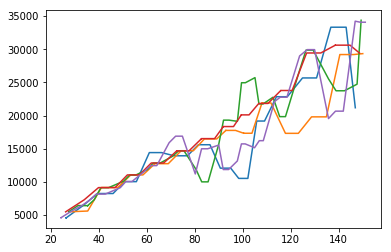

In [165]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://moe.eecs.qmul.ac.uk:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=10s' 
    return url+query+"&"+start+"&"+end+"&"+steps

def sumRows(df,col):
    total =[0]*len(df[col][df.first_valid_index()])
    for index,row in df.iterrows():
        i =0
        for val in row[col]:
            total[i]=total[i]+float(val)
            i+=1
    return total

def averageSet(allData):
    totalTests = len(allData)
    cpuMax = 0
    messageMax = 0
    for CPU,Messages in allData:
        cpuMax = max(len(CPU),cpuMax)
        messageMax = max(len(Messages),messageMax)
    totalCPU = [0]*cpuMax
    totalMessages = [0]*messageMax
    for CPU,Messages in allData:
        i =0
        for val in CPU:
            totalCPU[i]=totalCPU[i]+(float(val)/totalTests)
            i+=1
        i =0
        for val in Messages:
            totalMessages[i]=totalMessages[i]+(float(val)/totalTests)
            i+=1
    return (totalCPU,totalMessages)

def cpuVsMainMessages(start,end):
    mainMessages = requestData(queryRangeBuilder('raphtory_mainMessages',start,end))
    cpuUsage = requestData(queryRangeBuilder("rate(process_cpu_sum[180s])/rate(process_cpu_count[180s])",start,end))
    cpuUsage = cpuUsage[cpuUsage["metric.mode"] == "total"]
    joined = cpuUsage.merge(mainMessages, on=['metric.instance','metric.instance'], how='left')
    joined = joined[joined["metric.job_y"] == "prometheus"]
    joined["values_x"]=joined["values_x"].apply(lambda x: list(map((lambda y: y[1]),x)))
    joined["values_y"]=joined["values_y"].apply(lambda x: list(map((lambda y: y[1]),x)))
    totalCPU = sumRows(joined,"values_x")
    totalMessages = sumRows(joined,"values_y")
    return(totalCPU,totalMessages)

def plotIndividual(times):
    for start,end in times:
        totalCPU, totalMessages = cpuVsMainMessages(start,end)
        plt.plot(totalCPU, totalMessages)

def plotAverage(times):
    allData =[]
    for start,end in times:
        allData.append(cpuVsMainMessages(start,end))
    totalCPU, totalMessages = averageSet(allData)
    print(totalCPU)
    print(totalMessages)
    #plt.plot(totalCPU, totalMessages)
               
#cpuVsMainMessages("2019-05-31T13:49:10","2019-05-31T13:58:58")
times = []
times.append(("2019-05-31T21:27:19","2019-05-31T21:40:51"))
times.append(("2019-05-31T21:48:14","2019-05-31T22:01:26"))
times.append(("2019-05-31T22:09:22","2019-05-31T22:22:40"))
times.append(("2019-05-31T22:30:30","2019-05-31T22:43:48"))
times.append(("2019-05-31T22:51:16","2019-05-31T23:04:56"))

plotIndividual(times)


In [166]:
plotAverage(times)

[26.438620689655174, 26.43862068965517, 26.438620689655174, 26.438620689655174, 28.76248587570621, 33.45248587570621, 34.35915254237288, 34.359152542372875, 34.35915254237288, 34.359152542372875, 36.09104868913858, 39.55096129837703, 40.1376279650437, 40.1376279650437, 40.1376279650437, 42.15505385217631, 47.840377705833816, 51.650062421972535, 52.110062421972536, 52.110062421972536, 52.110062421972536, 53.6211536426924, 58.08783533295245, 61.649706049256615, 62.193039382589944, 62.193039382589944, 62.193039382589944, 63.81497806093692, 68.55655656473455, 72.24409431392577, 72.78742764725911, 72.78742764725911, 72.78742764725911, 74.24727084874314, 78.98285145434473, 82.37698826701732, 82.89921048923955, 82.89921048923955, 82.89921048923955, 84.5152154541428, 88.62352265687763, 91.57092789577291, 91.94648345132846, 91.94648345132846, 91.94648345132848, 93.24804294264229, 96.7264279852883, 99.13891147037988, 99.480022581491, 99.480022581491, 99.480022581491, 100.4494803167382, 103.82506

In [139]:

response = urllib.request.urlopen(queryRangeBuilder('raphtory_mainMessages',"2019-05-31T13:49:10","2019-05-31T13:58:58"))
parsed = json.load(response)["data"]["result"]
#print(parsed)
normalised = json_normalize(parsed)
print(normalised[normalised])

ValueError: Must pass DataFrame with boolean values only